<a href="https://colab.research.google.com/github/AnhelinaKavaliova/MachineLearning/blob/main/lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках

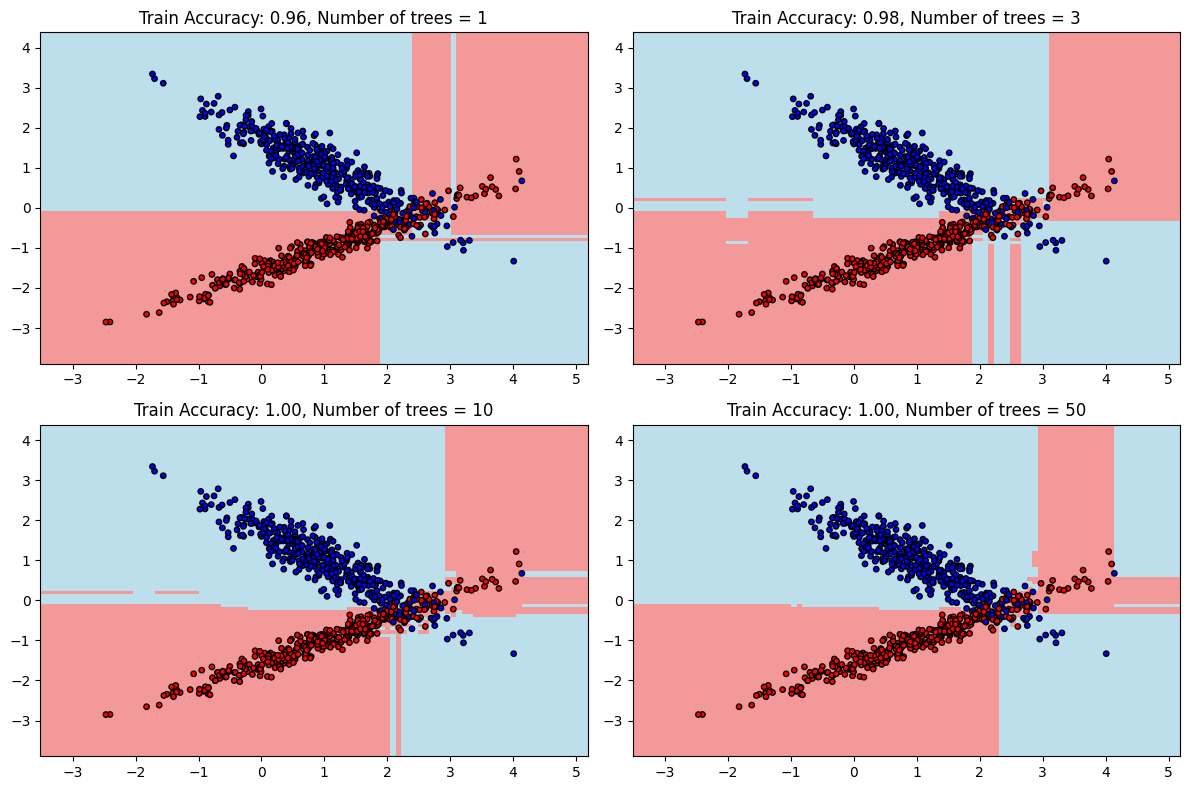

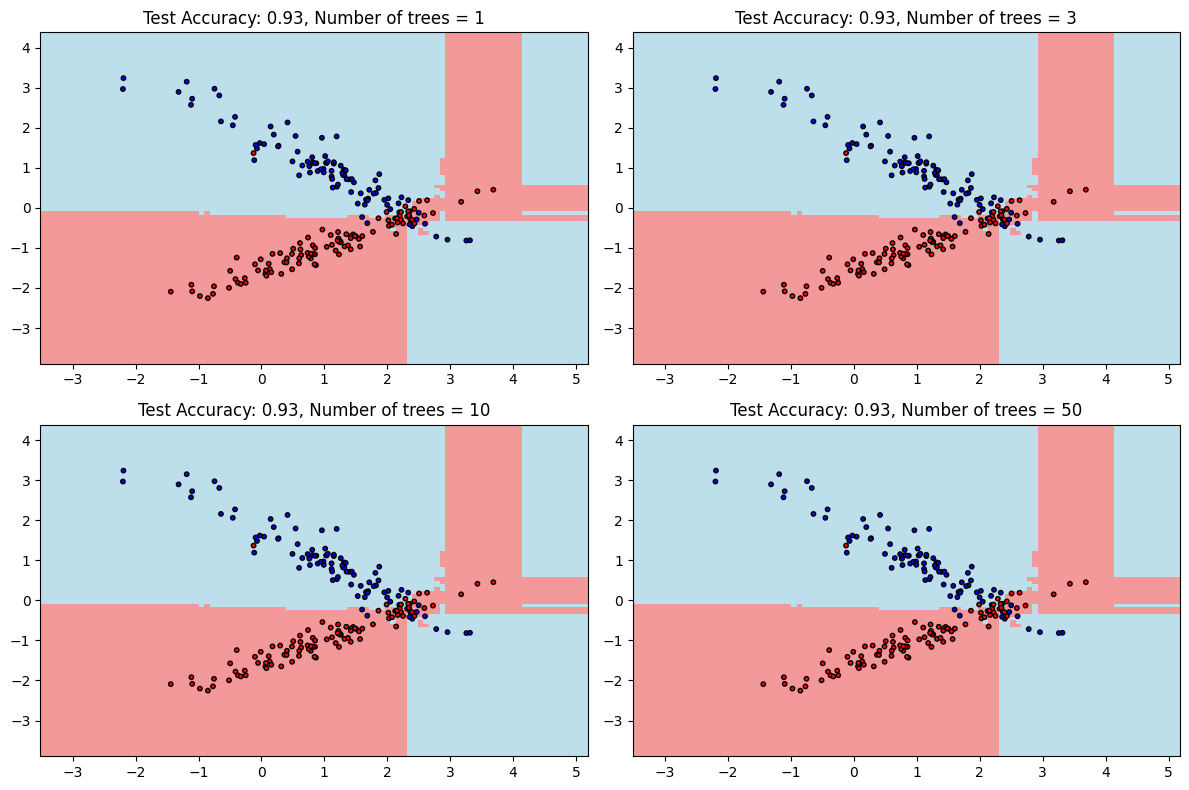

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, random_state=42)
n_estimators_list = [1, 3, 10, 50]

#cоздание цветовой схемы
cmap_light = ListedColormap(['lightcoral', 'lightblue'])
cmap_bold = ListedColormap(['red', 'blue'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#обучающий набор
plt.figure(figsize=(12, 8))
for i, n_estimators in enumerate(n_estimators_list, 1):

    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    plt.subplot(2, 2, i)
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
                         np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.8)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold, s=15, edgecolor='k')
    plt.title(f'Train Accuracy: {train_accuracy:.2f}, Number of trees = {n_estimators}')

plt.tight_layout()
plt.show()

#тестовый набор
plt.figure(figsize=(12, 8))
for i, n_estimators in enumerate(n_estimators_list, 1):
    plt.subplot(2, 2, i)
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
                         np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=10, edgecolor='k')
    plt.title(f'Test Accuracy: {test_accuracy:.2f}, Number of trees = {n_estimators}')

plt.tight_layout()
plt.show()



1. **Train Accuracy:**
   - При увеличении числа деревьев в случайном лесу от 1 до 10 точность на обучающей выборке растет: с 0.96 до 1
   - При увеличении числа деревьев модель становится более сложной и лучше подстраивается под обучающие данные

2. **Test Accuracy:**
   - Точность на тестовой выборке одинакова при разном количестве деревьев: 0.93
   - Модель хорошо обобщает данные и не переобучается с ростом числа деревьев.

Увеличение числа деревьев в случайном лесу повышает его сложность и позволяет лучше подстроиться под обучающие данные, но при этом модель остается достаточно обобщающей, чтобы хорошо работать на тестовых данных
Для этой конкретной задачи наилучшим выбором будет использование 3 деревьев в случайном лесу, так как это значение обеспечивает хорошее качество предсказания на тестовых данных, не приводя при этом к переобучению модели

#Реализация случайного леса. Поверка с помощью отложенной выборки на Out-of-Bag. Переписать функцию gini так, чтобы в качестве критерия использовалась энтропия Шэннона

In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

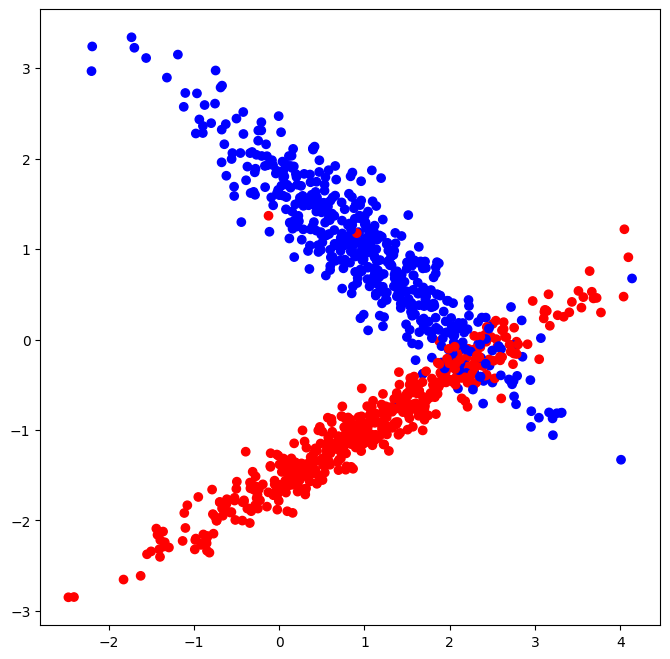

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1],
              c=y, cmap=cmap_bold);

In [ ]:
#бутстрап подвыборки и ооб индексы
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    oob_indices = []

    for i in range(N):
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        oob_index = np.setdiff1d(np.arange(n_samples), sample_index)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        oob_indices.append(oob_index)

    return bootstrap, oob_indices

In [ ]:
#подвыборка признаков
def get_subsample(len_sample):
  sample_indexes = list(range(len_sample))
  len_subsample = int(np.round(np.sqrt(len_sample)))
  subsample = np.random.choice(sample_indexes, size = len_subsample, replace = False)

  return subsample

In [ ]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        prediction = max(classes, key=classes.get)
        return prediction

In [ ]:
def entropy(labels):
  classes, count = np.unique(labels, return_counts = True)
  total_count = len(labels)
  p = count/total_count

  entropy = -np.sum(p * np.log2(p))

  return entropy

In [ ]:
def information_gain(left_labels, right_labels, root_entropy):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return root_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [ ]:
def split(data, labels, column_index, t):
  left = np.where(data[:, column_index] <= t)
  right = np.where(data[:, column_index] > t)
  true_data = data[left]
  false_data = data[right]
  true_labels = labels[left]
  false_labels = labels[right]

  return true_data, false_data, true_labels, false_labels

In [ ]:
def find_best_split(data, labels):
    root_entropy = entropy(labels)
    best_gain = 0
    best_t = None
    best_index = None
    n_features = data.shape[1]
    feature_subsample_indices = get_subsample(n_features)

    for index in feature_subsample_indices:
        t_values = np.unique(data[:, index])
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            current_gain = information_gain(true_labels, false_labels, root_entropy)
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [ ]:
def build_tree(data, labels):
    gain, t, index = find_best_split(data, labels)
    if gain == 0:
        return Leaf(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    return Node(index, t, true_branch, false_branch)

In [ ]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap, oob_indices = get_bootstrap(data, labels, n_trees)
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
    return forest, oob_indices

In [ ]:
def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes


In [ ]:
def tree_vote(forest, data):
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    predictions_per_object = list(zip(*predictions))
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
    return voted_predictions

In [ ]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:
def oob_score(forest, data, labels, oob_indices):
    n_trees = len(forest)
    oob_predictions = np.zeros(labels.shape[0], dtype=np.float64)

    for i in range(n_trees):
        tree = forest[i]
        oob_index = oob_indices[i]
        predictions = predict(data[oob_index], tree)
        oob_predictions[oob_index] += np.array(predictions)

    for i in range(labels.shape[0]):
        if oob_predictions[i] == 0:
            oob_predictions[i] = np.nan

    oob_predictions = np.nanmean(oob_predictions.reshape(n_trees, -1), axis=0)
    oob_predictions = np.round(oob_predictions).astype(int)

    return accuracy_metric(labels, oob_predictions)

In [ ]:
%%time
n_trees = 10
my_forest_1, oob_indices = random_forest(X, y, n_trees)

CPU times: user 4.32 s, sys: 14.8 ms, total: 4.33 s
Wall time: 4.66 s


In [ ]:
oob_accuracy = oob_score(my_forest_1, X, y, oob_indices)
print(f'Точность случайного леса из {n_trees} деревьев на ооб: {oob_accuracy:.2f}%')

Точность случайного леса из 10 деревьев на ооб: 92.24%


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rlf = RandomForestClassifier(n_estimators=10, oob_score=True,random_state=42)

rlf.fit(X,y)
oob_accuracy = rlf.oob_score_
print(f'Точность случайного леса из {n_trees} деревьев на ооб: {oob_accuracy:.2f}%')

Точность случайного леса из 10 деревьев на ооб: 0.92%


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


#xnjxnj

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Функция для получения бутстрапированных подвыборок и OOB индексов
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    oob_indices = []

    for _ in range(N):
        sample_index = np.random.choice(n_samples, size=n_samples, replace=True)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        oob_index = list(set(range(n_samples)) - set(sample_index))
        oob_indices.append(oob_index)
        bootstrap.append((b_data, b_labels))

    return bootstrap, oob_indices


In [ ]:
class Leaf:
    def __init__(self, prediction):
        self.prediction = prediction

class Node:
    def __init__(self, feature_index, threshold, left_branch, right_branch):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left_branch = left_branch
        self.right_branch = right_branch

In [ ]:
def entropy(labels):
    classes, counts = np.unique(labels, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))


In [ ]:
def split_node(data, labels, feature_index, threshold):
    left_mask = data[:, feature_index] <= threshold
    right_mask = data[:, feature_index] > threshold
    return data[left_mask], data[right_mask], labels[left_mask], labels[right_mask]

In [ ]:
def find_best_split(data, labels, num_features):
    best_gain = 0
    best_split = None
    root_entropy = entropy(labels)
    feature_indices = np.random.choice(data.shape[1], num_features, replace=False)

    for feature_index in feature_indices:
        thresholds = np.unique(data[:, feature_index])
        for threshold in thresholds:
            left_data, right_data, left_labels, right_labels = split_node(data, labels, feature_index, threshold)
            if len(left_labels) == 0 or len(right_labels) == 0:
                continue
            left_entropy = entropy(left_labels)
            right_entropy = entropy(right_labels)
            gain = root_entropy - (len(left_labels) / len(labels)) * left_entropy - (len(right_labels) / len(labels)) * right_entropy
            if gain > best_gain:
                best_gain = gain
                best_split = (feature_index, threshold, left_data, right_data, left_labels, right_labels)

    return best_split

In [ ]:
def build_tree(data, labels, num_features):
    if len(np.unique(labels)) == 1:
        return Leaf(labels[0])

    split = find_best_split(data, labels, num_features)
    if split is None:
        return Leaf(np.bincount(labels).argmax())

    feature_index, threshold, left_data, right_data, left_labels, right_labels = split
    left_branch = build_tree(left_data, left_labels, num_features)
    right_branch = build_tree(right_data, right_labels, num_features)
    return Node(feature_index, threshold, left_branch, right_branch)

In [ ]:
# Функция для классификации объекта
def classify_object(obj, node):
    if isinstance(node, Leaf):
        return node.prediction
    if obj[node.feature_index] <= node.threshold:
        return classify_object(obj, node.left_branch)
    else:
        return classify_object(obj, node.right_branch)

In [ ]:
# Функция для предсказания
def predict(data, tree):
    return [classify_object(obj, tree) for obj in data]

# Функция для вычисления точности
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:
def oob_score(forest, data, labels, oob_indices):
    n_samples = labels.shape[0]
    n_trees = len(forest)
    oob_predictions = np.zeros((n_samples, n_trees))
    counts = np.zeros(n_samples)

    # Заполнение предсказаний для OOB объектов
    for i, tree in enumerate(forest):
        oob_index = oob_indices[i]
        predictions = predict(data[oob_index], tree)
        for j, index in enumerate(oob_index):
            oob_predictions[index, i] = predictions[j]
            counts[index] += 1

    # Вычисление среднего значения предсказаний для каждого объекта
    oob_mean_predictions = np.zeros(n_samples)
    for i in range(n_samples):
        if counts[i] > 0:
            oob_mean_predictions[i] = np.sum(oob_predictions[i, :]) / counts[i]
        else:
            oob_mean_predictions[i] = np.nan

    # Убираем объекты, которые не имели ни одного OOB предсказания
    valid_indices = np.where(~np.isnan(oob_mean_predictions))[0]
    valid_predictions = oob_mean_predictions[valid_indices]
    valid_labels = labels[valid_indices]

    # Округление и преобразование в целые числа
    valid_predictions = np.round(valid_predictions).astype(int)

    return accuracy_metric(valid_labels, valid_predictions)

In [ ]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap, oob_indices = get_bootstrap(data, labels, n_trees)
    num_features = int(np.sqrt(data.shape[1]))
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, num_features))
    return forest, oob_indices

In [ ]:
n_trees = 10
my_forest_1, oob_indices = random_forest(X, y, n_trees)
oob_accuracy_custom = oob_score(my_forest_1, X, y, oob_indices)
print(f'Точность случайного леса из {n_trees} деревьев на OOB (custom): {oob_accuracy_custom:.2f}%')

# Реализация из библиотеки
clf = RandomForestClassifier(n_estimators=n_trees, oob_score=True, random_state=42)
clf.fit(X, y)
oob_accuracy_sklearn = clf.oob_score_
print(f'Точность случайного леса из {n_trees} деревьев на OOB (sklearn): {oob_accuracy_sklearn:.2f}%')

Точность случайного леса из 10 деревьев на OOB (custom): 93.03%
Точность случайного леса из 10 деревьев на OOB (sklearn): 0.92%


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
